Understanding these assumptions is crucial because if they are violated, the results of your linear regression (like the coefficients, p-values, and confidence intervals) might not be reliable or interpretable in the way we expect.

We will use the **Multiple Linear Regression (MLR) model** we just built with the Advertising dataset (`mlr_model` predicting `Sales` from `TV`, `Radio`, and `Newspaper`) to check these assumptions. The checks are primarily done on the **residuals** of the model, which are the differences between the actual values ($y$) and the predicted values ($\hat{y}$).

First, let's quickly get the predictions and residuals from our *training data*, as assumptions are typically checked on the data the model was built upon.

In [2]:
pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.8 MB 6.0 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/9.8 MB 6.5 MB/s eta 0:00:02
   ------------- -------------------------- 3.4/9.8 MB 6.5 MB/s eta 0:00:01
   ------------------- -------------------- 4.7/9.8 MB 6.4 MB/s eta 0:00:01
   ------------------------- -------------- 6.3/9.8 MB 6.4 MB/s eta 0:00:01
   ------------------------------ --------- 7.6/9.8 MB 6.5 MB/s eta 0:00:01
   ------------------------------------ --- 8.9/9.8 MB 6.5 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 6.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For prettier plots and some specific plots like Q-Q
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels.api as sm # For Durbin-Watson and Q-Q plot
from scipy import stats # For Shapiro-Wilk test and Q-Q plot

In [5]:
# 1. Load and Prepare Data (as before)
try:
    df_adv = pd.read_csv('Advertising.csv', index_col=0)
except FileNotFoundError:
    print("Error: 'Advertising.csv' not found. Please download it and place it in the correct directory.")
    exit()

X_mlr = df_adv[['TV', 'radio', 'newspaper']]
y_mlr = df_adv['sales']
X_train_mlr, X_test_mlr, y_train_mlr, y_test_mlr = train_test_split(X_mlr, y_mlr, test_size=0.2, random_state=42)

In [6]:
# 2. Fit the MLR model (if not already fitted in the session)
mlr_model = LinearRegression()
mlr_model.fit(X_train_mlr, y_train_mlr)

LinearRegression()

In [7]:
# 3. Get Predictions and Residuals on the TRAINING data
y_pred_train_mlr = mlr_model.predict(X_train_mlr)
residuals_train = y_train_mlr - y_pred_train_mlr

print("MLR Model successfully trained. Predictions and residuals for the training set are calculated.")
print(f"Number of training samples: {len(residuals_train)}")

MLR Model successfully trained. Predictions and residuals for the training set are calculated.
Number of training samples: 160


---
Now, let's go through each assumption:

**Assumptions of Linear Regression**
---

**A. Linearity**

* **What it means:** The underlying relationship between the independent variables (features) and the *mean* of the dependent variable (target) is linear. Our model equation $ \hat{y} = b_0 + b_1 X_1 + ... $ assumes this.
* **Why it's important:** If the true relationship is non-linear (e.g., curved), our linear model will be a poor approximation, leading to systematic errors in predictions (it will consistently over or under-predict in certain ranges).
* **How to check:**
    1.  **Residuals vs. Predicted values plot:** This is the most common and effective plot. If the linearity assumption holds, the residuals should be randomly scattered around the horizontal line at zero. There should be no discernible pattern (like a curve or U-shape).
    2.  **Residuals vs. Individual features plots:** Similar to the above, but plotting residuals against each feature separately.

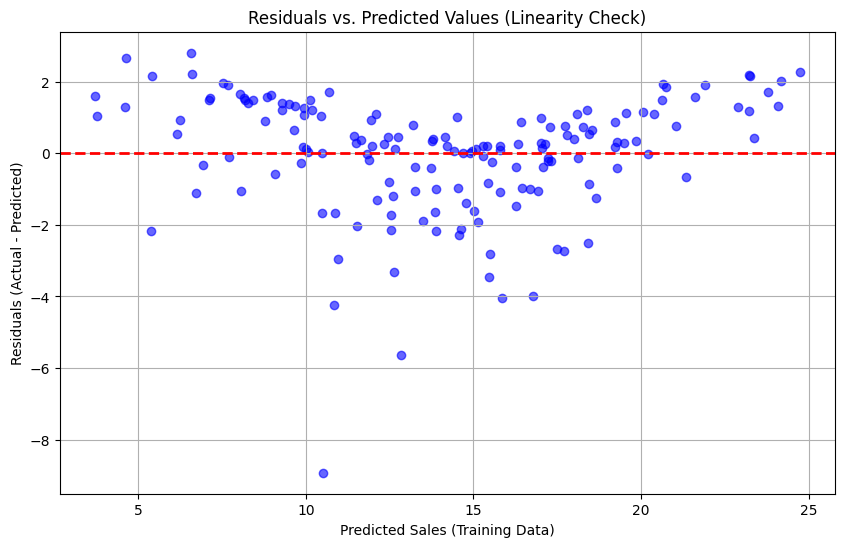

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train_mlr, residuals_train, alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle='--', lw=2) # Horizontal line at zero
plt.xlabel("Predicted Sales (Training Data)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values (Linearity Check)")
plt.grid(True)
plt.show()

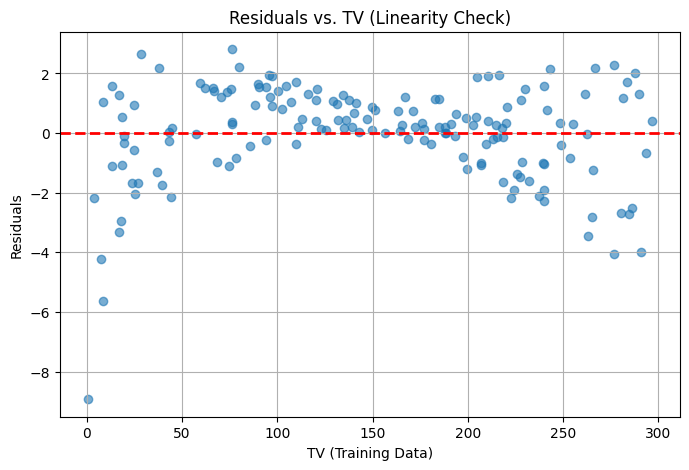

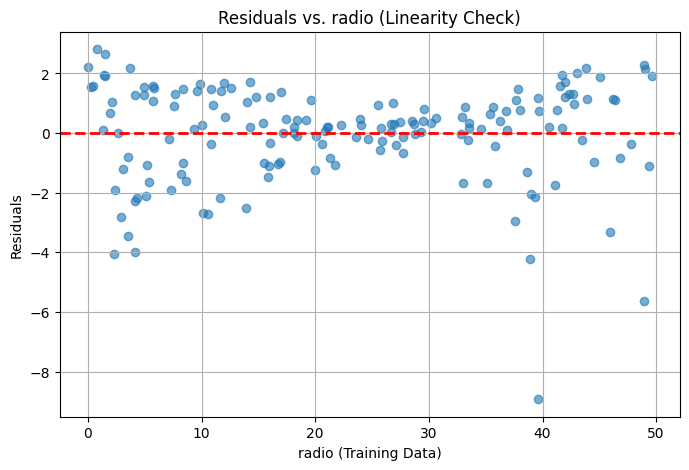

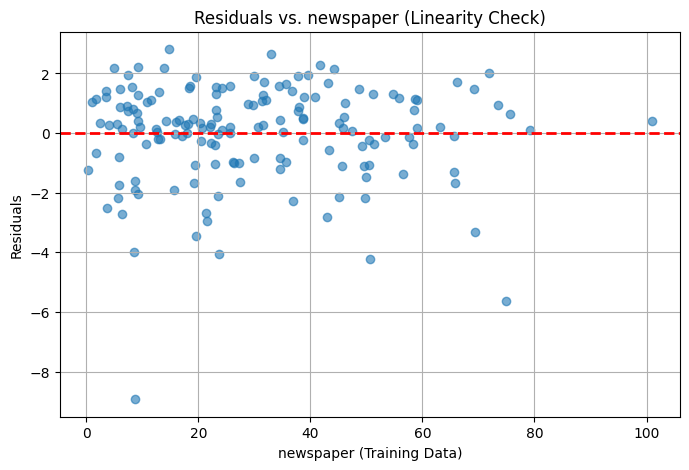

In [10]:
# You can also plot residuals vs. each independent variable
for column in X_train_mlr.columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(X_train_mlr[column], residuals_train, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel(f"{column} (Training Data)")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs. {column} (Linearity Check)")
    plt.grid(True)
    plt.show()

* **Interpretation:** Look at the plots. If you see a random cloud of points around the zero line, linearity is likely fine. If you see a curve (e.g., a U-shape or an inverted U), it suggests non-linearity. For the Advertising dataset, the relationship is reasonably linear, so you should see a fairly random scatter.
---

**B. Independence of Errors**

* **What it means:** The errors (residuals) are independent of each other. The error for one data point does not provide information about the error for another data point.
* **Why it's important:** If errors are correlated (e.g., positive autocorrelation where a positive error is likely followed by another positive error), our coefficient estimates are still unbiased, but their standard errors will be underestimated. This leads to narrower confidence intervals and smaller p-values than are accurate, potentially making us conclude that a variable is statistically significant when it's not. This is most common in time-series data.
* **How to check:**
    1.  **Residuals vs. Order of Data plot:** If your data has a natural sequence (like time), plot residuals against the sequence number. Look for patterns (e.g., trends, cyclical behavior). The Advertising dataset isn't time-series, so we can plot against the index.
    2.  **Durbin-Watson Test:** This is a formal test for autocorrelation.
        * The statistic ranges from 0 to 4.
        * Value around 2: No autocorrelation.
        * Value towards 0: Positive autocorrelation.
        * Value towards 4: Negative autocorrelation.
        (Rule of thumb: values between 1.5 and 2.5 are generally okay).

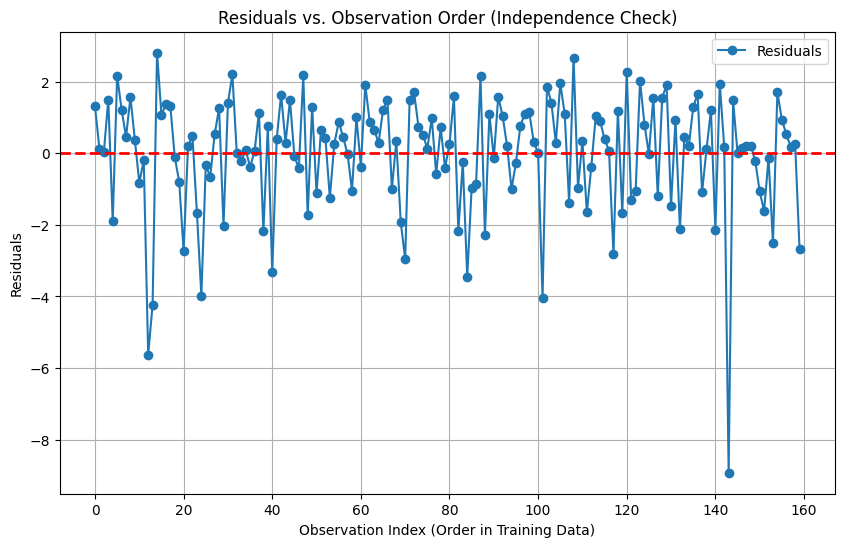

In [11]:
# 1. Plot residuals vs. index (order of data)
plt.figure(figsize=(10, 6))
plt.plot(residuals_train.values, marker='o', linestyle='-', label='Residuals') # .values to use numpy array for plotting
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Observation Index (Order in Training Data)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Observation Order (Independence Check)")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 2. Durbin-Watson Test (using statsmodels)
# Note: The Durbin-Watson test is typically applied to the residuals from a model
# that includes an intercept, which scikit-learn's LinearRegression does by default.
# For statsmodels, you might need to add an intercept explicitly if using its OLS.
# Here, we use the residuals from scikit-learn's model.
durbin_watson_statistic = sm.stats.stattools.durbin_watson(residuals_train)
print(f"\nDurbin-Watson statistic: {durbin_watson_statistic:.4f}")
if 1.5 < durbin_watson_statistic < 2.5:
    print("The Durbin-Watson statistic is within the acceptable range (around 2), suggesting no significant first-order autocorrelation.")
elif durbin_watson_statistic < 1.5:
    print("The Durbin-Watson statistic is low, suggesting possible positive autocorrelation.")
else:
    print("The Durbin-Watson statistic is high, suggesting possible negative autocorrelation.")


Durbin-Watson statistic: 2.1613
The Durbin-Watson statistic is within the acceptable range (around 2), suggesting no significant first-order autocorrelation.


* **Interpretation:** For the Advertising dataset (which is cross-sectional), strong autocorrelation is unlikely unless the data was collected in a specific order that introduced dependencies. The Durbin-Watson statistic should be around 2.
---

**C. Homoscedasticity (Constant Variance of Errors)**

* **What it means:** The variance of the errors is constant across all levels of the independent variables (or predicted values, $\hat{y}$). "Homo" means same, "scedasticity" means scatter/spread.
* **Why it's important:** If we have heteroscedasticity (non-constant variance – e.g., errors get larger as predicted values increase), the OLS coefficient estimates are still unbiased, but they are no longer the "best" (minimum variance). More critically, the standard errors of the coefficients are biased, leading to unreliable t-statistics and p-values for hypothesis testing and confidence intervals.
* **How to check:**
    1.  **Residuals vs. Predicted values plot:** This is the primary plot. Look for a consistent spread of residuals around the zero line. A "funnel" or "cone" shape (where the spread of residuals increases or decreases as predicted values change) indicates heteroscedasticity.
    2.  **Residuals vs. Individual features plots:** Can also reveal if variance changes with a specific feature.
    3.  **Statistical tests:** Breusch-Pagan test or Goldfeld-Quandt test (more formal, can be explored if visual checks are ambiguous).

* We already generated the main plot for linearity, let's re-emphasize what to look for regarding variance

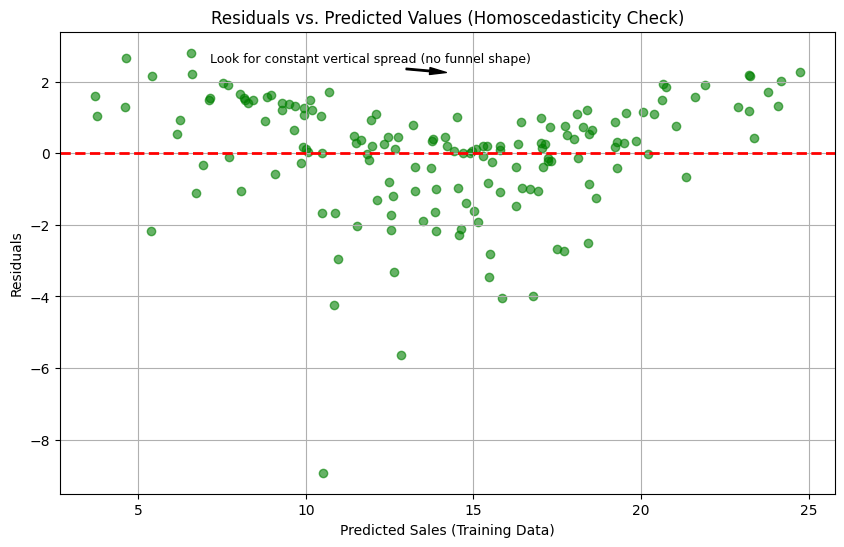

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train_mlr, residuals_train, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted Sales (Training Data)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Homoscedasticity Check)")
plt.annotate('Look for constant vertical spread (no funnel shape)',
             xy=(np.median(y_pred_train_mlr), np.max(residuals_train)*0.8),
             xytext=(np.median(y_pred_train_mlr)*0.5, np.max(residuals_train)*0.9),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
             fontsize=9)
plt.grid(True)
plt.show()

* **Interpretation:** Examine the vertical spread of the points. If it's roughly the same across the range of predicted values, homoscedasticity is likely met. The Advertising dataset might show slight heteroscedasticity, but often it's not severe.
---

**D. Normality of Errors**

* **What it means:** The errors (residuals) are normally distributed with a mean of zero.
* **Why it's important:** This assumption is particularly important for the validity of hypothesis tests (t-tests for coefficients, F-test for overall model significance) and the construction of confidence intervals, especially when the sample size is small. With large sample sizes (due to the Central Limit Theorem), moderate violations of normality might not be too detrimental for coefficient estimation, but inference can still be affected.
* **How to check:**
    1.  **Histogram of residuals:** Should look approximately bell-shaped.
    2.  **Q-Q (Quantile-Quantile) plot of residuals:** Residual quantiles are plotted against theoretical quantiles of a normal distribution. If residuals are normally distributed, the points should fall approximately along the 45-degree reference line.
    3.  **Statistical tests:** Shapiro-Wilk test or Kolmogorov-Smirnov test. Null hypothesis is that the data *is* normally distributed. A small p-value (< 0.05) suggests rejecting normality.

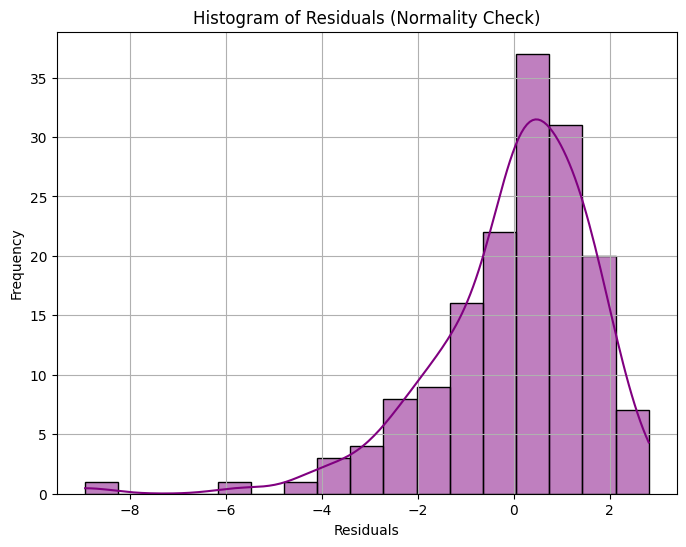

In [14]:
# 1. Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals_train, kde=True, color='purple') # kde=True adds a density curve
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals (Normality Check)")
plt.grid(True)
plt.show()

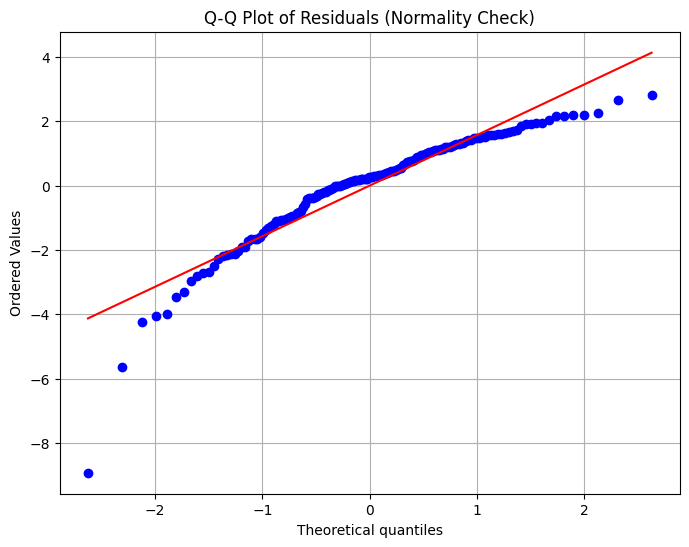

In [15]:
# 2. Q-Q plot of residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals_train, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Normality Check)")
plt.grid(True)
plt.show()

In [16]:
# 3. Shapiro-Wilk Test for normality
shapiro_stat, shapiro_p_value = stats.shapiro(residuals_train)
print(f"\nShapiro-Wilk Test for Normality of Residuals:")
print(f"  Statistic: {shapiro_stat:.4f}")
print(f"  P-value: {shapiro_p_value:.4f}")
alpha = 0.05
if shapiro_p_value > alpha:
    print("  The residuals look Normally distributed (fail to reject H0)")
else:
    print("  The residuals do not look Normally distributed (reject H0)")


Shapiro-Wilk Test for Normality of Residuals:
  Statistic: 0.8957
  P-value: 0.0000
  The residuals do not look Normally distributed (reject H0)


* **Interpretation:** The histogram should be roughly symmetric and bell-shaped. Points on the Q-Q plot should hug the diagonal line. For the Shapiro-Wilk test, if the p-value is greater than your chosen significance level (e.g., 0.05), you don't reject the null hypothesis of normality. The residuals for the Advertising data model are usually reasonably normal.
---

**E. No (or Little) Multicollinearity (for MLR)**

* **What it means:** The independent variables (features) are not highly correlated with each other. Perfect multicollinearity means one feature is a perfect linear combination of others. High multicollinearity means features are strongly, but not perfectly, related.
* **Why it's important (for high multicollinearity):**
    * **Unreliable Coefficients:** It becomes difficult for the model to disentangle the individual effect of each correlated feature on the target variable. Coefficients can have large standard errors, making them unstable (small changes in data can cause large changes in coefficients) and potentially have wrong signs or magnitudes.
    * **Interpretation Issues:** We can't confidently interpret a coefficient as the effect of one feature "holding others constant" if those others are strongly tied to it.
    * **Inflated Standard Errors:** This makes it harder to find statistically significant coefficients (p-values increase).
    * Note: Multicollinearity doesn't necessarily reduce the overall predictive accuracy of the model for the dataset as a whole, but it cripples the interpretability of individual coefficients.
* **How to check:**
    1.  **Correlation Matrix:** Calculate the correlation between all pairs of independent variables. Look for high absolute correlation values (e.g., > 0.7 or 0.8).
    2.  **Variance Inflation Factor (VIF):** VIF measures how much the variance of an estimated regression coefficient is increased because of multicollinearity.
        * VIF = 1: No multicollinearity for that feature.
        * 1 < VIF < 5: Moderate multicollinearity (often acceptable).
        * VIF > 5 or VIF > 10: High multicollinearity (problematic, warrants attention).
        The VIF for a feature $X_j$ is calculated as $1 / (1 - R_j^2)$, where $R_j^2$ is the R-squared from a regression of $X_j$ onto all other features.

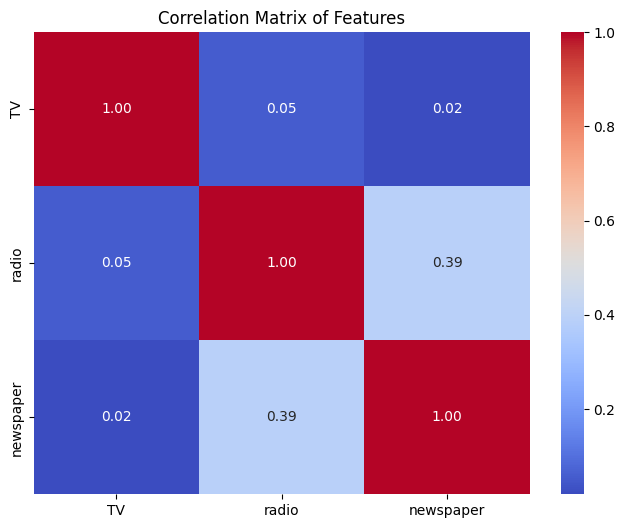


Correlation Matrix of Features:
                 TV     radio  newspaper
TV         1.000000  0.053872   0.019084
radio      0.053872  1.000000   0.388074
newspaper  0.019084  0.388074   1.000000


In [17]:
# 1. Correlation Matrix for independent variables
correlation_matrix = X_train_mlr.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

print("\nCorrelation Matrix of Features:")
print(correlation_matrix)

In [18]:
# 2. Variance Inflation Factor (VIF)
# Need to add a constant for VIF calculation if using statsmodels' function this way,
# or use it on the design matrix X.
# Simpler way: iterate through features.
def calculate_vif(df_features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_features.columns
    vif_data["VIF"] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]
    return vif_data.sort_values(by='VIF', ascending=False)

vif_df = calculate_vif(X_train_mlr) # Use the training features
print("\nVariance Inflation Factor (VIF):")
print(vif_df)


Variance Inflation Factor (VIF):
     feature       VIF
1      radio  3.488819
2  newspaper  3.273569
0         TV  2.502896


In [19]:
# Interpretation based on VIF values
if vif_df['VIF'].max() > 10:
    print("\nHigh multicollinearity detected (at least one VIF > 10).")
elif vif_df['VIF'].max() > 5:
    print("\nModerate multicollinearity detected (at least one VIF > 5).")
else:
    print("\nMulticollinearity is likely not an issue (all VIFs are low).")


Multicollinearity is likely not an issue (all VIFs are low).


* **Interpretation:** Check the correlation matrix for high values between pairs of features. Then look at the VIF scores. For the Advertising dataset, 'TV' and 'Radio' are usually not highly correlated, nor with 'Newspaper'. 'Newspaper' sometimes shows some correlation with 'Radio', but VIF scores are typically low for all three, indicating multicollinearity is not a major concern in this specific dataset.
---

**Important Note from your initial text:**
*"Violating these assumptions doesn't necessarily mean the model can't make any predictions, but it undermines the reliability and interpretability of the coefficients and statistical tests. The model might still predict well if the underlying relationship is approximately linear."* This is a key takeaway. The severity and impact depend on which assumption is violated and to what extent.

This covers the core assumptions of linear regression and how to check them. Each check gives you valuable insight into your model's validity.